# Zadanie 6

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 8 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1.5 pkt]
- Wnioski [1.5 pkt]


In [1]:
import numpy as np
import gymnasium as gym
import gymnasium.spaces as spaces
import matplotlib.pyplot as plt

In [2]:
# https://stackoverflow.com/questions/67779374/deprecationwarning-np-bool
import warnings

warnings.filterwarnings(
    action="ignore",
    category=DeprecationWarning,
    message="`np.bool8` is a deprecated alias",
)

In [3]:
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py#L404
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py#L293
# W CliffWalkingEnv okno pygame nie jest zamykane
from gymnasium.envs.toy_text.cliffwalking import CliffWalkingEnv


def close_env(self):
    if self.window_surface is not None:
        import pygame

        pygame.display.quit()
        pygame.quit()


CliffWalkingEnv.close = close_env

In [4]:
# Interfejs


class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(
        self,
        observation_space: np.array,
        action_space: np.array,
        learning_rate: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 0.1,
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.observation_weights = np.append([1], np.cumprod(self.observation_space))[:-1]
        self.action_weights = np.append([1], np.cumprod(self.action_space))[:-1]
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.q = np.zeros((np.prod(self.observation_space), np.prod(self.action_space)))

    def _encode(self, sample, weights):
        return np.dot(sample, weights)

    def _decode(self, sample, weights, space):
        # space = 5, 2, 10
        # cumprod = 5, 10, 100
        # weights = 1, 5, 10
        # sample = 3, 0, 8
        # 3 + 0*2 + 8*10 = 83
        # 83 // 10 = 8 -> 8 % 10 = 8
        # 83 // 5 = 16 -> 16 % 2 = 0
        # 83 // 1  = 83 -> 83 % 5 = 3
        return (sample // weights) % space

    def _encode_state(self, state):
        return self._encode(state, self.observation_weights)

    def _encode_action(self, action):
        return self._encode(action, self.action_weights)

    def _decode_action(self, action):
        return self._decode(action, self.action_weights, self.action_space)

    def __call__(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:
        """Return Q-value of given state and action."""
        state = self._encode_state(state)
        action = self._encode_action(action)
        return self.q[state, action]

    def update(
        self, state: np.ndarray, action: np.ndarray, next_state: np.array, reward: float
    ) -> None:
        """Update Q-value of given state and action."""
        state = self._encode_state(state)
        next_state = self._encode_state(next_state)
        action = self._encode_action(action)
        self.q[state, action] += self.learning_rate * (
            reward + self.gamma * np.max(self.q[next_state, :]) - self.q[state, action]
        )

    def get_best_action(self, state: np.ndarray) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        state = self._encode_state(state)
        action = np.argmax(self.q[state, :])
        return self._decode_action(action)

    def choose_action(self, state: np.ndarray, random_action: np.ndarray) -> np.ndarray:
        if np.random.uniform() <= self.epsilon:
            return random_action
        else:
            return self.get_best_action(state)

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        pass

    def __str__(self):
        return self.__repr__()

In [5]:
class GymLearningEnvironment:
    def __init__(
        self,
        env_name,
        learning_rate: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 0.1,
    ) -> None:
        env = gym.make(env_name)
        self.env_name = env_name
        self.qls = QLearningSolver(
            self._encode_space(env.observation_space),
            self._encode_space(env.action_space),
            learning_rate=learning_rate,
            gamma=gamma,
            epsilon=epsilon,
        )
        env.close()

    def _loop(self, n, learn=True, env=None, max_steps=1000, aggregate=None):
        rewards = []
        if env is None:
            env = gym.make(self.env_name)
        if aggregate is None:
            aggregate = np.sum
        for _ in range(n):
            state, info = env.reset()
            state = self._encode(state)
            episode_rewards = []
            for _ in range(max_steps):
                action = (
                    self.qls.choose_action(
                        state, self._encode(env.action_space.sample())
                    )
                    if learn
                    else self.qls.get_best_action(state)
                )
                observation, reward, terminated, truncated, info = env.step(
                    self._decode(action)
                )
                observation = self._encode(observation)
                if learn:
                    self.qls.update(state, action, observation, reward)
                state = observation
                episode_rewards.append(reward)
                if terminated or truncated:
                    break
            rewards.append(aggregate(episode_rewards))
        env.close()
        return np.array(rewards)

    def learn(self, n):
        return self._loop(n, learn=True)

    def show(self, n, env=None):
        return self._loop(
            n, learn=False, env=gym.make(self.env_name, render_mode="human")
        )

    def avg_reward(self, n, aggregate=None):
        return np.mean(self._loop(n, learn=False, aggregate=aggregate))

    @staticmethod
    def _encode_space(space):
        if isinstance(space, spaces.Tuple):
            return np.array([s.n for s in space.spaces])
        assert isinstance(space, spaces.Discrete)
        return np.array([space.n])

    @staticmethod
    def _decode(action_or_state):
        if action_or_state.size == 1:
            return action_or_state[0]
        else:
            return tuple(action_or_state)

    @staticmethod
    def _encode(action_or_state):
        if isinstance(action_or_state, tuple):
            return np.array(action_or_state)
        else:
            return np.array([action_or_state])

# Eksperymenty

In [6]:
class Environment:
    def __init__(self, name, aggregate) -> None:
        self.name = name
        self.aggregate = aggregate

In [7]:
environment_names = ["Blackjack-v1", "Taxi-v3", "CliffWalking-v0", "FrozenLake-v1"]
last = lambda arr: arr[-1]

# win game: +1
# lose game: -1
# draw game: 0
blackjack = Environment("Blackjack-v1", last)

# -1 per step unless other reward is triggered.
# +20 delivering passenger.
# -10 executing “pickup” and “drop-off” actions illegally.
taxi = Environment("Taxi-v3", np.sum)

# Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward.
cliff = Environment("CliffWalking-v0", np.mean)

# Reach goal(G): +1
# Reach hole(H): 0
# Reach frozen(F): 0
lake = Environment("FrozenLake-v1", last)

In [8]:
taxi.gle = GymLearningEnvironment(taxi.name)
taxi.gle.learn(10_000)

array([-533, -551, -578, ...,    7,    8,    4])

# Symulacja

In [9]:
taxi.gle.show(1)

array([8])

In [10]:
def plot_accuracy(env, max_episodes=10_000, step=100, avg=20, title=None, **kwargs):
    gle = GymLearningEnvironment(env.name, **kwargs)
    ys = []
    xs = []
    for i in range(step, max_episodes + step, step):
        ys.append(gle.avg_reward(avg, env.aggregate))
        xs.append(i)
        gle.learn(step)
    plt.plot(xs, ys)
    plt.title(env.name if title is None else title)
    plt.xlabel(f"Liczba epizodów (co {step})")
    plt.ylabel(f"Funkcja nagrody (średnia z {avg})")
    plt.show()
    return gle

# Wpływ $\epsilon$

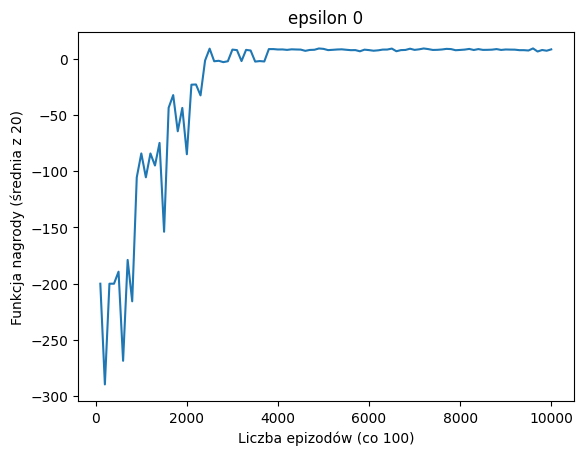

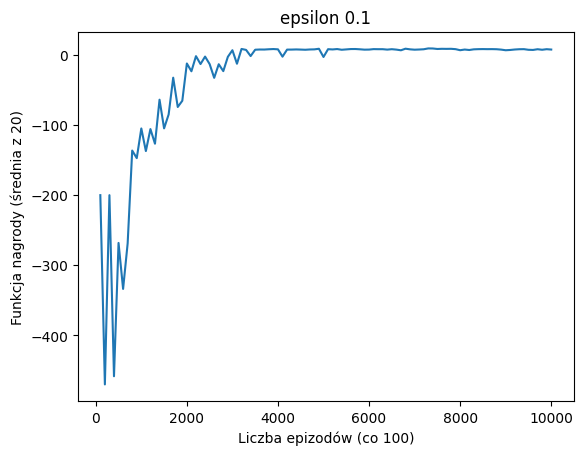

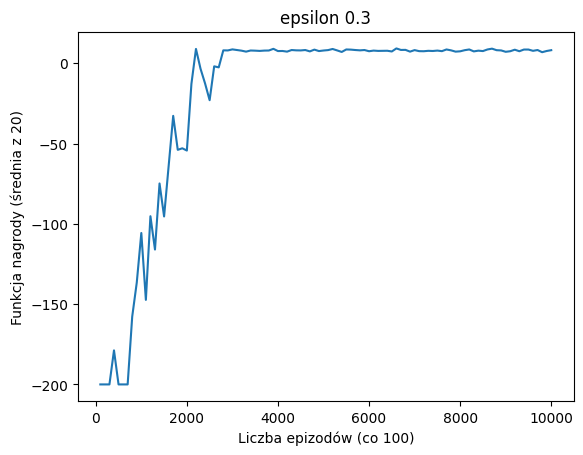

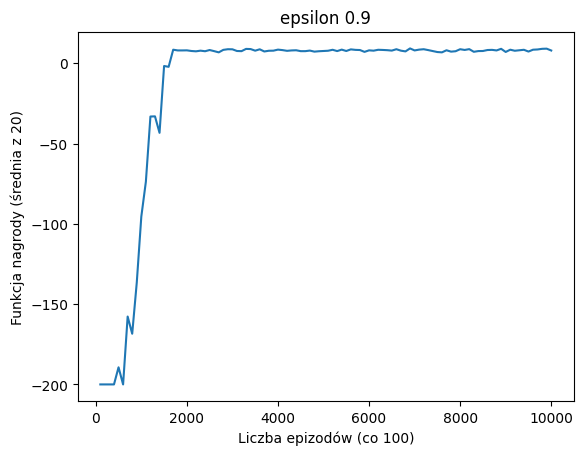

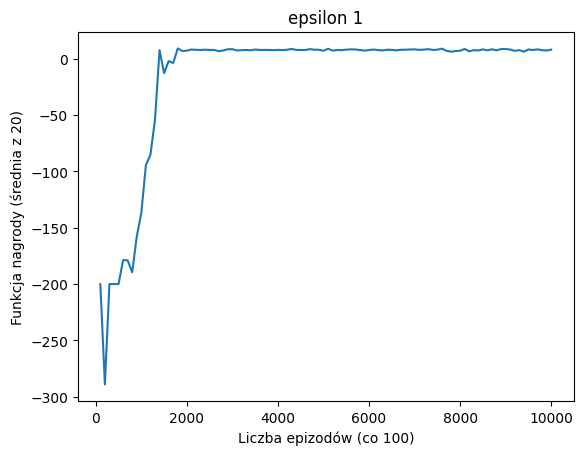

In [11]:
for epsilon in [0, 0.1, 0.3, 0.9, 1]:
    plot_accuracy(
        taxi, title=f"epsilon {epsilon}", max_episodes=10_000, epsilon=epsilon
    )

# Wypływ $\gamma$

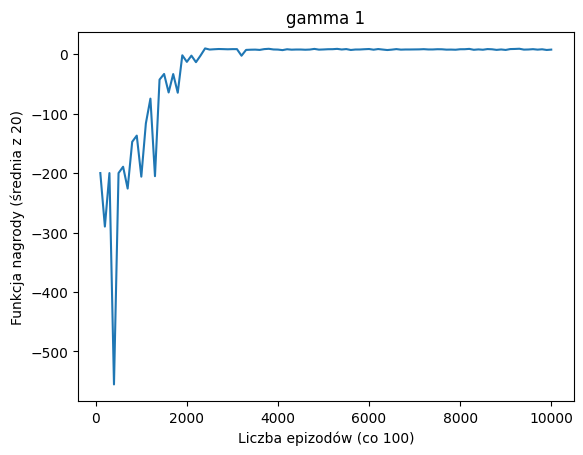

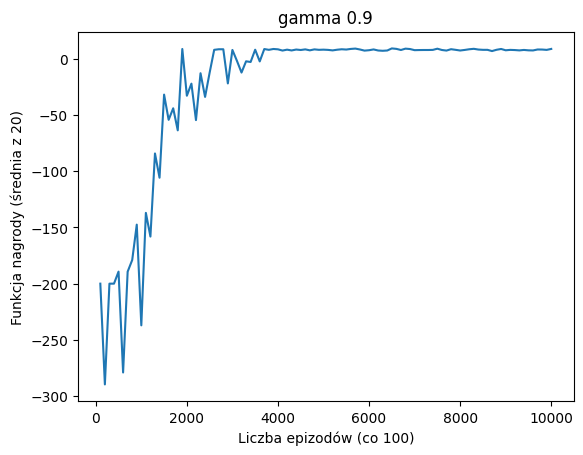

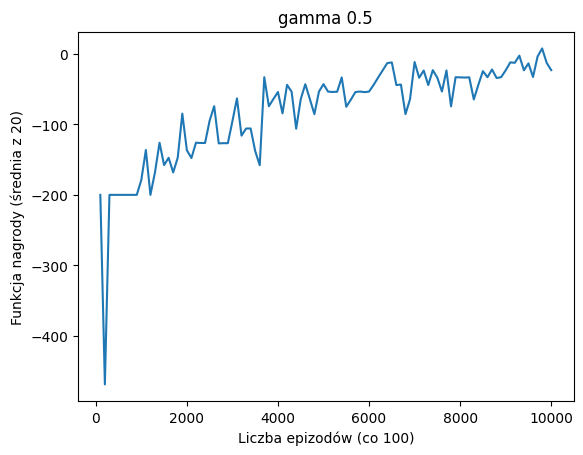

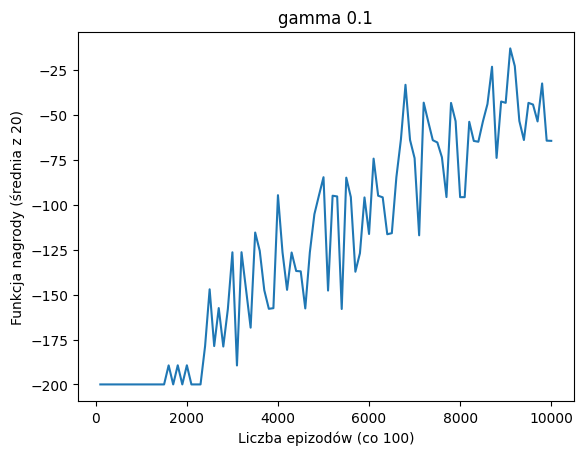

In [12]:
for gamma in [1, 0.9, 0.5, 0.1]:
    plot_accuracy(taxi, title=f"gamma {gamma}", max_episodes=10_000, gamma=gamma)

Niska wartość $\gamma$ spowalnia uczenie.

# Wpływ $\alpha$

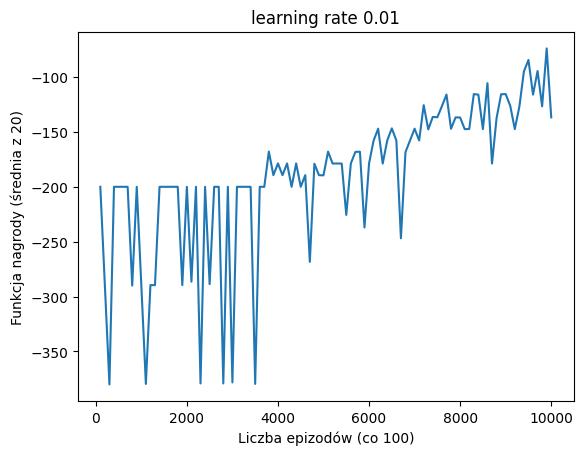

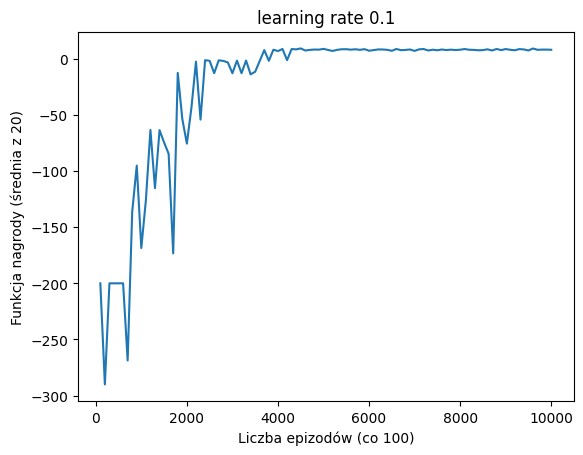

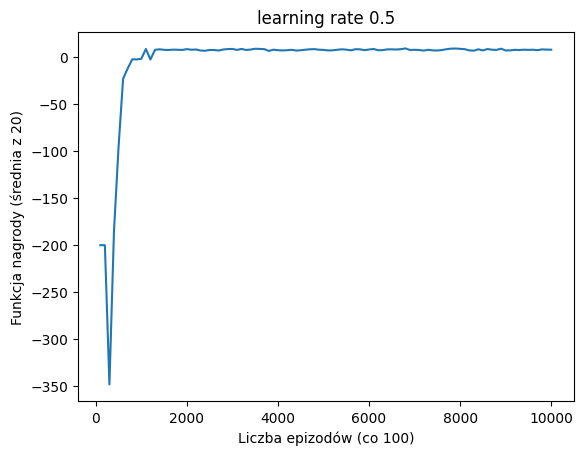

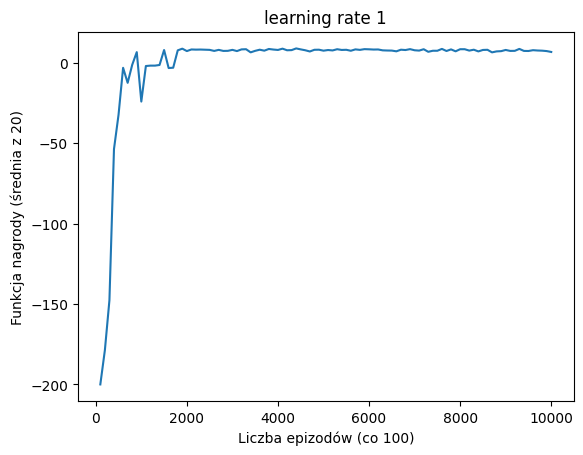

In [13]:
for alpha in [0.01, 0.1, 0.5, 1]:
    plot_accuracy(
        taxi, title=f"learning rate {alpha}", max_episodes=10_000, learning_rate=alpha
    )

# Inne środowiska

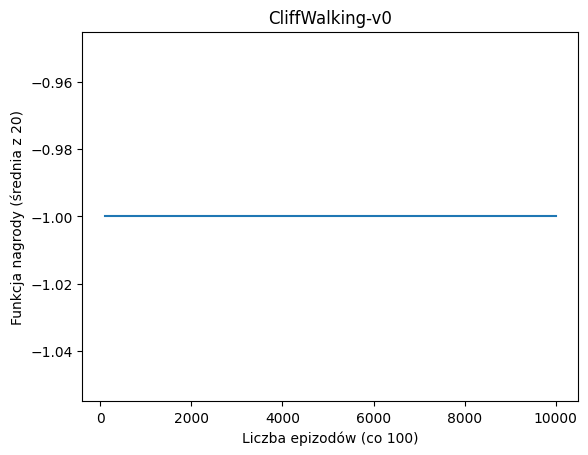

In [14]:
cliff.gle = plot_accuracy(cliff, max_episodes=10_000)

In [15]:
cliff.gle.show(1)

array([-13])

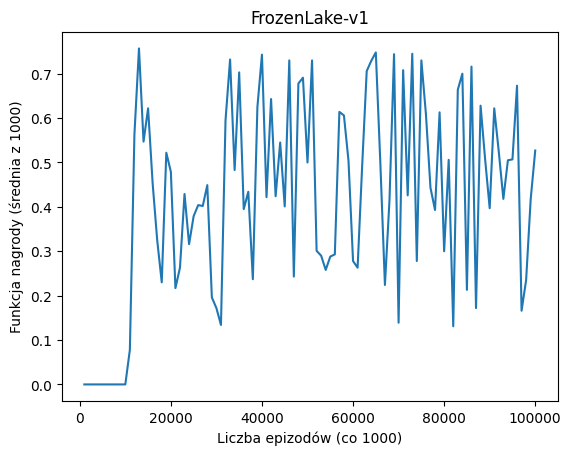

In [16]:
lake.gle = plot_accuracy(lake, max_episodes=100_000, step=1_000, avg=1_000)

In [17]:
lake.gle.show(10)

array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])

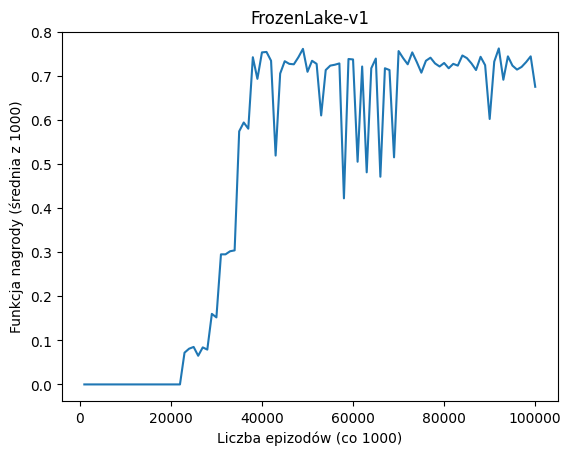

In [18]:
lake.gle = plot_accuracy(
    lake, max_episodes=100_000, step=1_000, avg=1_000, learning_rate=0.01
)

In [19]:
lake.gle.show(1)

array([1.])

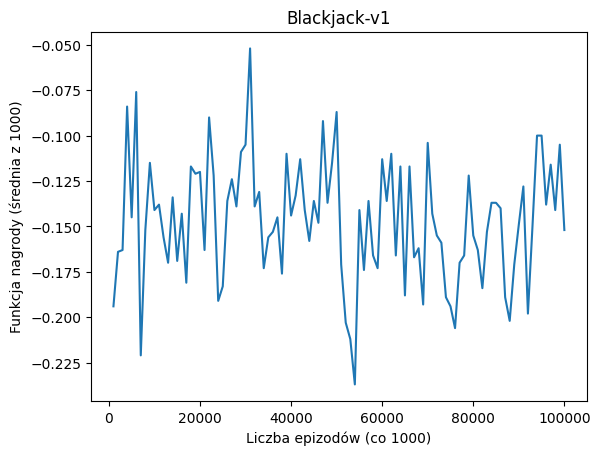

In [20]:
blackjack.gle = plot_accuracy(blackjack, max_episodes=100_000, step=1_000, avg=1_000)

In [21]:
blackjack.gle.show(1)

array([1.])

https://web.stanford.edu/class/aa228/reports/2020/final17.pdf

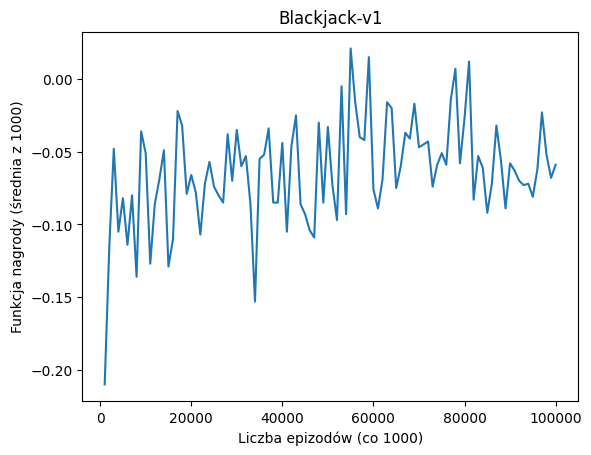

In [22]:
blackjack.gle = plot_accuracy(
    blackjack,
    max_episodes=100_000,
    step=1_000,
    avg=1_000,
    learning_rate=0.01,
    gamma=0.1,
)

In [23]:
blackjack.gle.show(1)

array([-1.])

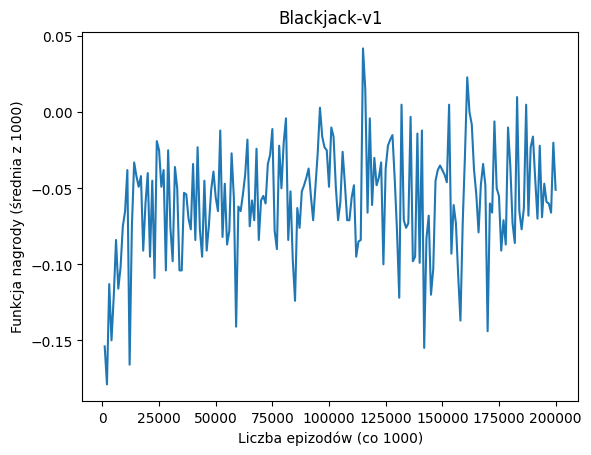

In [24]:
blackjack.gle = plot_accuracy(
    blackjack,
    max_episodes=200_000,
    step=1_000,
    avg=1_000,
    learning_rate=0.01,
    gamma=0.1,
    epsilon=0.01,
)

In [25]:
blackjack.gle.show(1)

array([-1.])

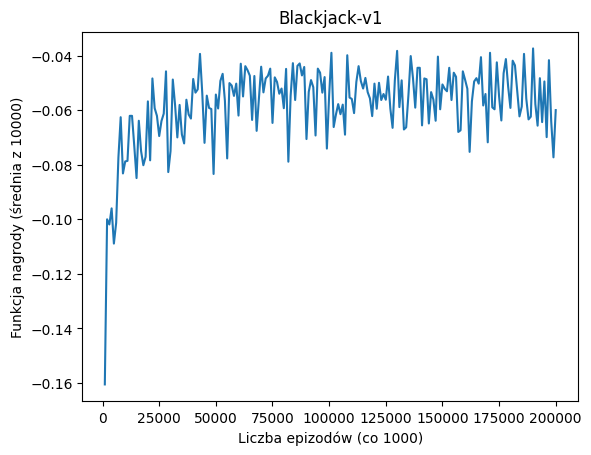

In [26]:
blackjack.gle = plot_accuracy(
    blackjack,
    max_episodes=200_000,
    step=1_000,
    avg=10_000,
    learning_rate=0.01,
    gamma=0.1,
    epsilon=0,
)

In [27]:
blackjack.gle.show(1)

array([-1.])

# Wnioski

Dla stabilnego uczenia wartość gamma powinna być równa 0.9. Mniejsze wartości spowalniają uczenie.

Bardzo duża wartość epsilon spowalnia uczenie. Ze względu na prostotę środowiska algorytm uczy się dobrze nawet dla 0, ponieważ jest tylko jedno rozwiązanie i poztywna nagroda jest tylko za jego znalezienie.

Przy małej wartości współczynnika uczenia uczenie przebiega zbyt wolno dla prostych problemów. Dla nich dobrze działa nawet wartość 1.
Dla bardziej niestabilnych problemów (FrozenLake i Blackjack) wartość 0.01 daje lepsze wyniki.